<a href="https://colab.research.google.com/github/GiacomoDiFa/Progetto-MN/blob/main/progetto_MN_Di_Fabrizio_Montanari.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.integrate

Compile the following notebook and share a link with me sending and e-mail to giovanni.stabile@uniurb.it at least one week before the oral examination. All the implemented function will have to be properly documented and commented.

Compile The following Cell with your information. In case it is a group project, put the info for all the group members

Name1: Giacomo \
Surname1: Di Fabrizio\
Email1: g.difabrizio@campus.uniurb.it

Name2: Matteo Marco\
Surname2: Montanari\
Email2: m.montanari41@campus.uniurb.it

Consider the following one-dimensional PDE:
$$
-u_{xx}(x) = f(x)\quad\mathrm{ in }\ \Omega = (0, \pi)
$$
$$
u(x) = 0, \quad\mathrm{ on }\ \partial\Omega = \{0, \pi\}
$$

Given the following $4^{th}$ order finite difference approximation of the second order derivative:

$$u_{xx}(x_i) = \frac{-u_{i-2}+16u_{i-1}-30u_i+16u_{i+1}-u_{i+2}}{12h^2}$$

Implement a function that given the domain interval, the forcing function, the number of discretization points, the boundary conditions, returns the matrix $A$ and the the right hand side $b$.

# Mathematical Background

The physical interpretation of this problem is related to the modelling of an elastic string, which occupies at rest the space $[0, \pi]$ and is fixed at the two extremes. The unknown $u(x)$ represents the displacement of the string at the point $x$, and the right-hand side models a prescribed force $f(x)$ on the string.

For the numerical discretization of the problem, we consider a **Finite Difference (FD) Approximation**. Let $n$ be an integer, a consider a uniform subdivision of the interval $(0,\pi)$ using $n$ equispaced points, denoted by $\{x_i\}_{i=0}^n$ . Moreover, let $u_i$ be the FD approximation of $u(x_i)$, and similarly $f_i \approx f(x_i)$.

In order to formulate the discrete problem, we consider a FD approximation of the left-hand side, as follows ($4^{th}$ order finite difference approximation of the second order derivative):

$$u_{xx}(x_i) \approx \frac{-u_{i-2}+16u_{i-1}-30u_i+16u_{i+1}-u_{i+2}}{12h^2} \qquad \text{for} \qquad  i = 2, ..., n-2$$

while we use the $2^{th}$ order finite difference approximation of the second order derivative for the remaining points $(i = 1, n-1)$:

$$
-u_{xx}(x_i) \approx \frac{-u_{i-1} + 2u_i - u_{i+1}}{h^2} \qquad \text{for} \qquad  i = 1, n-1
$$

being $h = \frac{\pi}{n-1}$ the size of each subinterval $(x_i, x_{i+1})$.

Finally the problem that we need to solve is

$$
(P) =
\begin{cases}
\begin{align}
u_i &= 0 \qquad\qquad\qquad i=0\\
\frac{-u_{i-1} + 2u_i - u_{i+1}}{h^2} &= f_i \qquad\qquad\qquad i=1\\
\frac{-u_{i-2}+16u_{i-1}-30u_i+16u_{i+1}-u_{i+2}}{12h^2} &= - f_i \qquad\qquad\qquad i=2, \ldots, n-2\\
\frac{-u_{i-1} + 2u_i - u_{i+1}}{h^2} &= f_i \qquad\qquad\qquad i=n-1\\
u_i &= 0 \qquad\qquad\qquad i=n\\
\end{align}
\end{cases}
$$

Then, let us collect all the unknowns $\{u_i\}_{i=0}^n$ in a vector $\mathbf{u}$. Then, $(P)$ is a linear system

$$
A \mathbf{u} = \mathbf{f}
$$

then $A$ is the matrix:

\begin{bmatrix}
1  & 0  & 0  & 0 & 0 & 0 & 0 & 0 & 0\\
-1/h^2 & +2/h^2 & -1/h^2 & 0 & 0 & ... & ... & ... & 0\\
-1/12h^2 & +16/12h^2 & -30/12h^2 & +16/12h^2 & -1/12h^2 & 0 & ... & ... & 0\\
0 & -1/12h^2 & +16/12h^2 & -30/12h^2 & +16/12h^2 & -1/12h^2 & 0 & ... & 0\\
0 & 0 & -1/12h^2 & +16/12h^2 & -30/12h^2 & +16/12h^2 & -1/12h^2 & 0 & 0\\
0 & ... & 0 & ... & ... & ... & ... & ... & 0 \\
0 & ... & ... & 0 & -1/12h^2 & +16/12h^2 & -30/12h^2 & +16/12h^2 & -1/12h^2\\
0 & ... & ... & ... & 0 & 0 & -1/h^2 & +2/h^2 & -1/h^2\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1\\
\end{bmatrix}

In [2]:
# 4th order finite difference scheme
def finDif(omega, f, n, bc):
    """
    The function generate the linear system of equation (Ax = b)
    implementing the 4th order finite difference scheme for
    a general PDE in the form:
    
    -u_xx(x) = f(x)
    
    with boundary condition u(x_0) = bc[0] and u(x_n) = bc[1]. 
    
    Parameters
    ----------
    omega (list): extremes of the domain of the PDE.
    f (func): prescribed force applied to the elastic string.
    n (int): number of discretization points.
    bc (list): boundary conditions.

    Returns
    -------
    A (nxn matrix): matrix resulting from the linear system generated 
                    from the PDE.
    termine_noto (list(double)): known term of the linear system.
    """
    
    assert n > 4, "n must be greater than 4!"
    assert omega[0] < omega[1], "Discretization interval is not correct!" 
    
    # d(x, y) = | x - y |
    h = np.abs(omega[0] - omega[1]) / (n - 1)
        
    x = np.linspace(omega[0], omega[1], n)    
    
    # 4th order approximation term
    termine_noto = -f(x)
    # 2th order approximation term
    termine_noto[1] = f(x[1])
    termine_noto[-2] = f(x[-2])
    # boundary conditions
    termine_noto[0] = bc[0]
    termine_noto[-1] = bc[1]

    # create discretization matrix A
    A = np.zeros((n, n))
  
    a = -np.ones((n-2, )) 
    b = 16*np.ones((n-1, ))
    c = -30*np.ones((n, ))

    A = (np.diag(a, -2) + np.diag(a, +2) + np.diag(b, -1) + np.diag(b, +1) + np.diag(c, 0))

    A /= (12*h**2)
    
    A[0, :] = np.zeros(n)
    A[1, :] = np.zeros(n)

    A[n-1, :] = np.zeros(n)
    A[n-2, :] = np.zeros(n)

    A_second_row = np.array([-1.0, 2.0, -1.0]) / (h**2)
    A_second_last_row = np.array([-1.0, 2.0, -1.0]) / (h**2)
    
    A[1, 0:3] = A_second_row
    A[n-2, n-3:n] = A_second_last_row
  
    A[0, 0] = 1
    A[-1, -1] = 1

    return A, termine_noto

In [3]:
omega = [0, np.pi]
f = lambda x : np.sin(x)
n = 6
bc = [0, 0]
A, b = finDif(omega, f, n, bc)
print("A =")
print(A)

A =
[[ 1.          0.          0.          0.          0.          0.        ]
 [-2.53302959  5.06605918 -2.53302959  0.          0.          0.        ]
 [-0.2110858   3.37737279 -6.33257398  3.37737279 -0.2110858   0.        ]
 [ 0.         -0.2110858   3.37737279 -6.33257398  3.37737279 -0.2110858 ]
 [ 0.          0.          0.         -2.53302959  5.06605918 -2.53302959]
 [ 0.          0.          0.          0.          0.          1.        ]]


Implement two functions that compute the LU and the Cholesky factorization of the system matrix $A$

In [4]:
# LU factorization of matrix A
def LU(A):
    """
    The function implements the LU factorization of the
    matrix A.
    
    Parameters
    ----------
    A (nxn matrix): real value matrix.
    
    Returns
    -------
    L (nxn matrix): inferior triangular factorization of A.
    U (nxn matrix): superior triangular factorization of A.
    """
    A = A.copy()
    N = len(A)
    for k in range(N-1):
        if (abs(A[k,k]) < 1e-15):
            raise RuntimeError("Null pivot")
            
        A[k+1:N,k] /= A[k,k]
        
        for j in range(k+1,N):
            A[k+1:N,j] -= A[k+1:N,k]*A[k,j]
    
    L = np.tril(A)
    
    for i in range(N):
        L[i,i] = 1.0
    
    U = np.triu(A)
    
    return L, U

In [5]:
# cholesky factorization
def cholesky(A):
    """
    The function implements the Cholesky factorization of the
    matrix A.
    
    Parameters
    ----------
    A (nxn matrix): real value matrix.
    
    Returns
    -------
    L (nxn matrix): inferior triangular factorization of A.
    L.T (nxn matrix): superior triangular factorization of A.
    """
    A = A.copy()
    N = len(A)
    for k in range(N-1): 
        A[k,k] = np.sqrt(A[k,k])
        A[k+1:N,k] = A[k+1:N,k]/A[k,k]
        
        for j in range(k+1,N):
            A[j:N,j] = A[j:N,j] - A[j:N,k]*A[j,k]
        
    A[-1,-1] = np.sqrt(A[-1,-1])
    L = np.tril(A)
    
    return L, L.transpose()

Implement forward and backward substitution functions to exploit the developed factorization methods to solve the derived linear system of equations.

In [6]:
# forward substitution
def L_solve(L, rhs):
    """
    The function implements the forward substitution to solve
    the linear system in the form Lx = rhs.
    
    Parameters
    ----------
    L (nxn matrix): inferior triangular factorization of A.
    rhs (list(double)): right hand side of the system of equation.
    
    Returns
    -------
    x (list(double)): solution of the system.
    """
    x = np.zeros_like(rhs)
    N = len(L)
        
    x[0] = rhs[0]/L[0,0]
    
    for i in range(1,N):
        x[i] = (rhs[i] - np.dot(L[i, 0:i], x[0:i]))/L[i,i]
    
    return x

In [7]:
# backward substitution
def U_solve(U, rhs):
    """
    The function implements the backward substitution to solve
    the linear system in the form Ux = rhs.
    
    Parameters
    ----------
    U (nxn matrix): superior triangular factorization of A.
    rhs (list(double)): right hand side of the system of equation.
    
    Returns
    -------
    x (list(double)): solution of the system.
    """
    x = np.zeros_like(rhs)
    N = len(U)
              
    x[-1] = rhs[-1]/U[-1,-1]
    
    for i in reversed(range(N-1)):
        x[i] = (rhs[i] -np.dot(U[i, i+1:N], x[i+1:N]))/U[i,i]
    
    return x

Solve the derived linear system using the implemented functions and plot the computed solution:

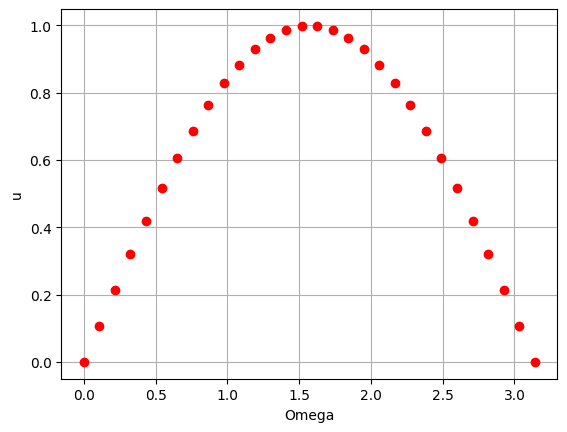

In [8]:
# parameters setting
omega = [0, np.pi]
f = lambda x : np.sin(x)
n = 30
bc = [0, 0]

# create and solve the linear system
A, b = finDif(omega, f, n, bc)
L, U = LU(A)
w = L_solve(L, b)
u = U_solve(U, w)

# plot the solution
x = np.linspace(omega[0], omega[1], n)
plt.plot(x, u, 'ro')
plt.xlabel('Omega')
plt.ylabel('u')
plt.grid()

Considering the new domain $\Omega = (0,1)$ and the forcing term $f(x) = x(1-x)$ with B.C. $u(x) = 0$, on $\partial \Omega = \{0,1\}$ produce a plot and a table where you show the decay of the error w.r.t. the number of grid points.
(The analytical solution for the above problems is $u_{an} = \frac{x^4}{12} - \frac{x^3}{6} + \frac{x}{12}$)

Errore: 2.3176179749389897e-07


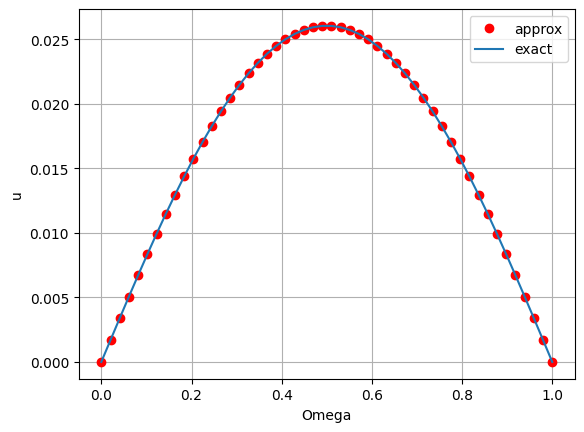

In [9]:
# Problem definition is changed!
# parameters setting
omega_new = [0, 1]
n_new = 50
x_new = np.linspace(omega_new[0], omega_new[1], n_new)
f_new = lambda x_new : x_new*(1 - x_new)
bc_new = [0, 0]

# solving the system of equation
A_new, b_new = finDif(omega_new, f_new, n_new, bc_new)
A1_new = A_new.copy()
#u_new = np.linalg.solve(A1_new, b_new)
L_new, U_new = LU(A1_new)
w_new = L_solve(L_new, b_new)
u_new = U_solve(U_new, w_new)

# exact solution
u_ex = (x_new**4)/12.0 - (x_new**3)/6.0 + x_new/12.0

# Plot the FD and exact solution
plt.plot(x_new, u_new, 'ro', label='approx')
plt.plot(x_new, u_ex, label='exact')
plt.xlabel('Omega')
plt.ylabel('u')
plt.legend()
plt.grid()

print('Errore:', np.linalg.norm(u_ex - u_new, 2))

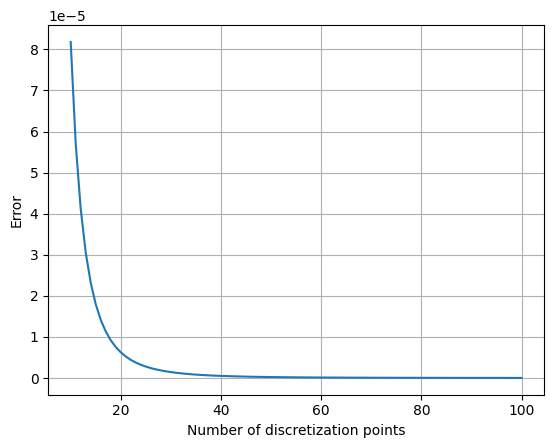

In [10]:
# plot the decay of the error w.r.t. the number of grid points
omega_new = [0, 1]
bc_new = [0, 0]

error = []
n_points = np.array([x for x in range(10, 101)])

for j in n_points:
    x_new = np.linspace(omega_new[0], omega_new[1], j)
    f_new = lambda x_new : x_new*(1 - x_new)
    u_ex = (x_new**4)/12.0 - (x_new**3)/6.0 + x_new/12.0

    A_new, b_new = finDif(omega_new, f_new, j, bc_new)
    A1_new = A_new.copy()
    u_new = np.linalg.solve(A1_new, b_new) 
    
    error.append(np.linalg.norm(u_ex - u_new, 2))
    
plt.plot(n_points, error)
plt.xlabel('Number of discretization points')
plt.ylabel('Error')
plt.grid()

In [11]:
# table where you show the decay of the error w.r.t. the number of grid points
tab = {n : e for n, e in zip(n_points, error)}
tab

{10: 8.182104913849225e-05,
 11: 5.706190043777708e-05,
 12: 4.115278746829856e-05,
 13: 3.051750491708503e-05,
 14: 2.3168609617246354e-05,
 15: 1.7946045414151817e-05,
 16: 1.4144027486156257e-05,
 17: 1.1317631361057197e-05,
 18: 9.177619391578304e-06,
 19: 7.5308382678810345e-06,
 20: 6.2452039891759625e-06,
 21: 5.2284696168144255e-06,
 22: 4.4149840113946926e-06,
 23: 3.757224437859193e-06,
 24: 3.2202585849810886e-06,
 25: 2.778048103188456e-06,
 26: 2.4109352684829296e-06,
 27: 2.1039050656594176e-06,
 28: 1.8453647937521708e-06,
 29: 1.6262747785589246e-06,
 30: 1.4395210936619862e-06,
 31: 1.2794573244936942e-06,
 32: 1.1415661472512682e-06,
 33: 1.02220659077801e-06,
 34: 9.184236512359627e-07,
 35: 8.278033812434153e-07,
 36: 7.483617302630032e-07,
 37: 6.784586031810024e-07,
 38: 6.167308304879536e-07,
 39: 5.620396296155551e-07,
 40: 5.134289901314642e-07,
 41: 4.7009270690330147e-07,
 42: 4.313478956282996e-07,
 43: 3.9661375274939795e-07,
 44: 3.6539433808174925e-07,
 4

Exploit the derived LU factorizations to compute the determinant of the system's matrix $A$ using the original problem formulation.

In [12]:
def determinant(A):
    """
    The function calculate the determinant of a real matrix A.
    
    Parameters
    ----------
    A (nxn matrix): a real (invertible) matrix A.
    
    Returns
    -------
    determinant (double): determinant of A.
    """
    L, U = LU(A)
    size = A.shape[0]
    determinant = 1
    
    for i in range(size):
        determinant *= U[i, i]

    return determinant

print('determinant(A):', determinant(A))
print('NumPy:', np.linalg.det(A))

determinant(A): 1.5889036569020528e+57
NumPy: 1.58890365690221e+57


In [13]:
# conditioning number
def condNum(A):
    return np.linalg.norm(A, 2) * np.linalg.norm(np.linalg.inv(A), 2)

print('condNum(A):', condNum(A))
print('NumPy:', np.linalg.cond(A))

condNum(A): 1799.0384017511979
NumPy: 1799.03840175115


Implement a preconditioned Conjugant Gradient method to solve the original linear system of equations using an iterative method:

In [14]:
def conjugate_gradient(A, b, P, nmax, eps=1e-10):
    """
    The function implements the conjugate gradient method to 
    solve the linear system of equations in the form PAx = b.
    
    Parameters
    ----------
    A (nxn matrix): matrix A of the system in the form PAx = b.
    b (list(double)): right hand side of the system of equation.
    P (nxn matrix): preconjugation matrix.
    nmax (int): maximum number of iterations (<= len(A)).
    eps (double): tollerance to stop the method (default is 1e-10).
    
    Returns
    -------
    x (list(double)): solution of the system.
    """
    if nmax <= len(A):
        N = nmax
    else:
        N = len(A)
    
    assert N > 1, "Maximum number of iterations must be positive integer!"
    
    x = np.zeros_like(b)
    tol = eps + 1
    it = 0
    r = b - np.dot(A,x)
    rho_old = 1.
    p_old = np.zeros_like(b)
    
    while (it < N and tol > eps):
        it += 1
        z = np.linalg.solve(P,r)
        rho = np.dot(r,z)
        
        if (it > 1):
            beta = rho/rho_old
            p = z + beta*p_old
        else:
            p = z
        
        q = np.dot(A,p)
        alpha = rho/(np.dot(p,q))
        x += p*alpha
        r -= q*alpha
        
        p_old = p
        rho_old = rho
        
        tol = np.linalg.norm(r, 2)
        
    print('n iterazioni:\t', it)
    print('Tolleranza:\t', tol)
    return x

n iterazioni:	 50
Tolleranza:	 1.9029288605195382
Errore:		 0.02153880165907125


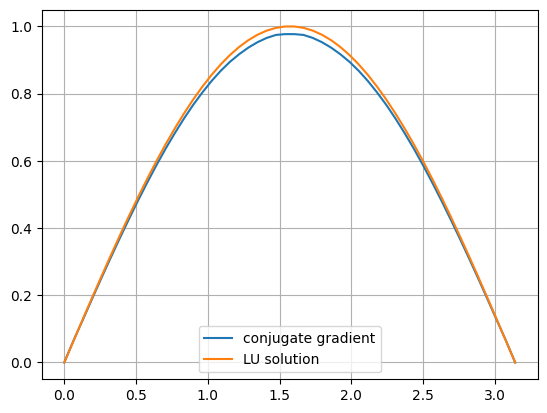

In [15]:
# parameters setting
omega2 = [0, np.pi]
f2 = lambda x : np.sin(x)
n2 = 50
bc2 = [0, 0]

# create and solve the linear system (exact method)
A2, b2 = finDif(omega2, f2, n2, bc2)
L2, U2 = LU(A2)
w2 = L_solve(L2, b2)
u2 = U_solve(U2, w2)

# solving the system and plot the solutions (iterative method)
sol_conjugate_gradient = conjugate_gradient(A2, b2, np.identity(len(A2)), n2)
print('Errore:\t\t', np.linalg.norm(sol_conjugate_gradient - u2)/np.linalg.norm(u2))

x_new2 = np.linspace(omega2[0], omega2[1], n2)
plt.plot(x_new2, sol_conjugate_gradient, label='conjugate gradient')
plt.plot(x_new2, u2, label='LU solution')
plt.legend()
plt.grid()

Consider the following time dependent variation of the PDE starting from the orginal problem formulation:
$$
u'(t)-u_{xx} = \alpha(t)f(x)
$$

for $t\in [0,T]$, with $\alpha(t) = \cos(t)$ and $T = 6\pi$

Use the same finite difference scheme to derive the semi-discrete formulation and solve it using a forward Euler's method.

Plot the time dependent solution solution at $x = \pi/2$, $x=1$, 
$x=\pi$


### Mathematical Background

Let's recall that, to solve this PDE in both time and space, we use the following notation (time and space discretization):

$$ x_i = i \Delta x $$
$$ t^n = n \Delta t$$
$$ u_i^n = u(x_i, t^n) = u(i \Delta x, n \Delta t) $$

**Note** that $u = u(x, t)$ depends both on space and time.

We use a first order forward discretization of the first order derivative of $u$ in time:

$$ u'(t) \approx \frac{u_i^{n+1} - u_i^{n}}{\Delta t}$$

While we use a second order central discretization of the second order derivative of $u$ in space:

$$ u_{xx} = u_{xx}(x) \approx \frac{u_{i+1}^n - 2 u_i^n + u_{i-1}^n}{(\Delta x)^2 }$$

Let's recall the PDE we are studing:

$$
u'(t)-u_{xx} = \alpha(t)f(x)
$$

And remember that:

$$ \alpha(t)f(x) \approx \alpha (t^n) f(x_i) = cos(t^n) sin(x_i) $$ 

This led to the following formulation of our PDE:

$$ u'(t) - u_{xx} = \frac{u_i^{n+1} - u_i^{n}}{\Delta t} - \frac{u_{i+1}^n - 2 u_i^n + u_{i-1}^n}{(\Delta x)^2 } = \alpha (t) f(x) $$

that is:

$$ \frac{u_i^{n+1} - u_i^{n}}{\Delta t} - \frac{u_{i+1}^n - 2 u_i^n + u_{i-1}^n}{(\Delta x)^2 } = \alpha (t^n) f(x_i)$$

Finally we can write the updating step formula in both time and space:

$$ u_i^{n+1} = u_i^{n} + \Delta t \frac{u_{i+1}^n - 2 u_i^n + u_{i-1}^n}{(\Delta x)^2 } + \Delta t \cdot \alpha (t^n) \cdot f(x_i) $$

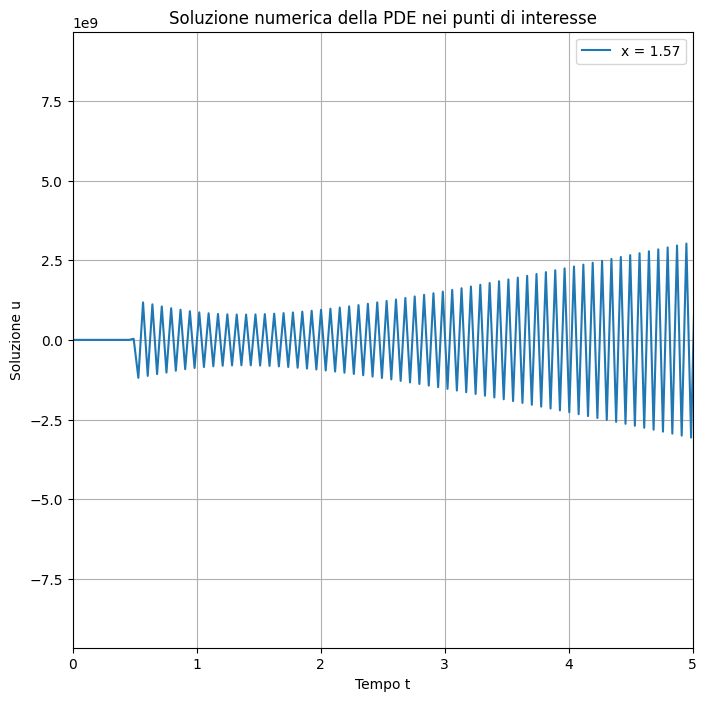

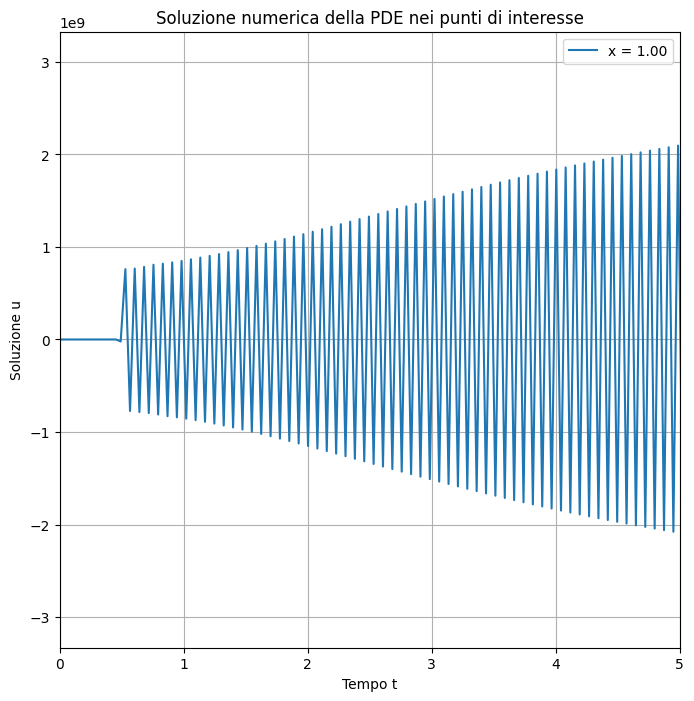

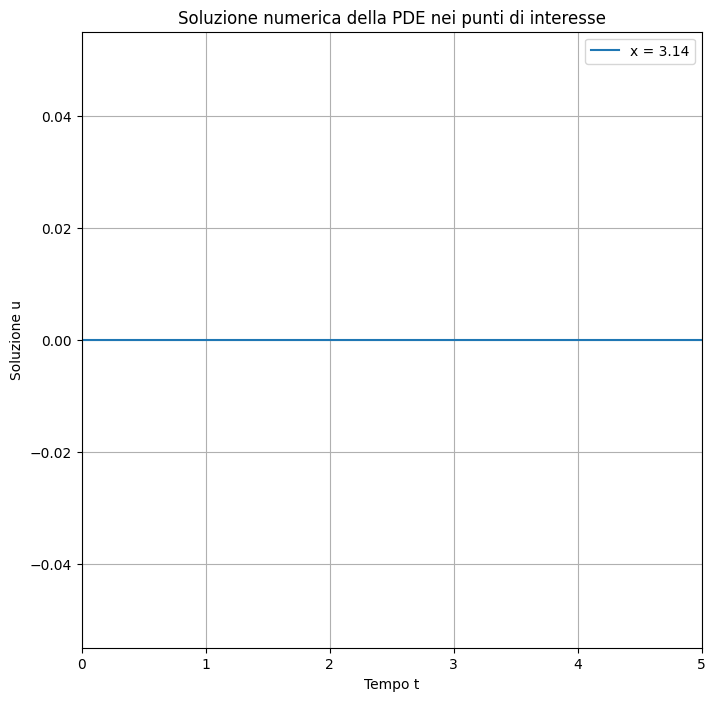

In [16]:
###### DISCAIMER !!! ########
# non essendo riusciti a risolvere la PDE diversamente abbiamo seguito 
# l'approccio utilizzato nel corso di Simulazione Numerica

# Parametri del problema
L = np.pi          # Lunghezza del dominio spaziale
T = np.pi*6        # Tempo finale
Nx = 100           # Numero di punti discreti nello spazio
Nt = 500           # Numero di punti discreti nel tempo
dx = L / (Nx - 1)  # Passo spaziale
dt = T / Nt        # Passo temporale

# Funzione alpha(t)
def alpha(t):
    return np.cos(t)  

# Funzione f(x)
def f(x):
    return np.sin(x) 

# Inizializzazione della griglia spaziale
x = np.linspace(0, L, Nx)

# Inizializzazione della griglia temporale
t = np.linspace(0, T, Nt)

# Inizializzazione delle condizioni iniziali
u0 = 0  

u = np.zeros((Nt, Nx))
u[0, :] = u0

# Iterazione temporale e spaziale
for n in range(Nt - 1):
    for i in range(1, Nx - 1):
        u[n + 1, i] = u[n, i] + dt * ((u[n, i+1] - 2*u[n, i] + u[n, i-1]) / dx**2 + alpha(t[n]) * f(x[i]))

    # Gestione degli overflow
    max_value = np.max(u[n + 1, :])
    if max_value > 1e10:
        u[n + 1, :] /= max_value / 1e10

# Punti di interesse
x_points = [np.pi / 2, 1, np.pi]

# Trova gli indici dei punti di interesse nel dominio spaziale
x_indices = [np.abs(x - point).argmin() for point in x_points]

# Estrai la soluzione nei punti di interesse
solution_points = u[:, x_indices]

# Plot della soluzione nei punti di interesse
for i, point in enumerate(x_points):
    plt.figure(figsize=(8, 8))
    plt.xlim([0, 5])
    plt.plot(t, solution_points[:, i], label=f'x = {point:.2f}')
    plt.xlabel('Tempo t')
    plt.ylabel('Soluzione u')
    plt.title('Soluzione numerica della PDE nei punti di interesse')
    plt.legend()
    plt.grid()
    plt.show()

Given the original $Au = b$ system, implement an algorithm to compute the largest and smallest eigenvalues and the associated eigenvectors of the matrix $A$.

In [17]:
# let's implement Power Method
z0 = np.ones_like(b)

def PM(A, z0, tol=1e-8, nmax=500):
    """
    The function implements the power method to solve the
    find the largest eigenvalue and eigenvector of matrix A.
    
    Parameters
    ----------
    A (nxn matrix): a real matrix.
    z0 (list(double)): initial value for the eigenvector.
    tol (double): tollerance to stop the method (default is 1e-8).
    nmax (int): maximum number of iterations (default is 500).
    
    Returns
    -------
    l (double): largest eigenvalue of A.
    q (list(double)): largest eigenvector of A.
    """
    z = z0  
    it = 0
    eps = tol + 1
    
    while (it < nmax and eps > tol):
        it += 1
        
        q = z / (np.linalg.norm(z))

        if (it == 1):
            l_km1 = q.T @ z
        else:
            l_km1 = l.copy()

        z = A @ q

        l = q.T @ z

        #eps = np.linalg.norm(l_km1 - l) / np.linalg.norm(l)

        # Ax = lx <=> ||Ax - lx||_2 = 0
        eps = np.linalg.norm(A @ q - l * q, 2) 
    
    print("Iterazioni:", it, "\nTolleranza:", eps)

    return l, q

In [18]:
# compute PM
l, x = PM(A, z0)
# use numpy library for comparing    
l_np, x_np = np.linalg.eig(A)

print("l_max =", l, "\nx_max =", x)
print("\nNumpy Linalg")

print("l_max =", max(abs(l_np)), "\nx_max =", x_np[:, np.argmax(abs(l_np))])

Iterazioni: 434 
Tolleranza: 9.903458235023709e-09
l_max = -446.7457230903773 
x_max = [ 0.         -0.00816844 -0.05916244  0.11907579 -0.17273854  0.21698049
 -0.24940597  0.26824824 -0.27248117  0.26187421 -0.23700504  0.19922808
 -0.15060076  0.09377141 -0.03183507 -0.03183507  0.09377141 -0.15060076
  0.19922808 -0.23700504  0.26187421 -0.27248117  0.26824824 -0.24940597
  0.21698049 -0.17273854  0.11907579 -0.05916244 -0.00816844  0.        ]

Numpy Linalg
l_max = 452.52051003589867 
x_max = [ 0.          0.0040733   0.02977818 -0.06111087  0.09172653 -0.12108255
  0.14878484 -0.17445458  0.19774112 -0.21832634  0.23592903 -0.25030873
  0.26126899 -0.26866008  0.27238105 -0.27238105  0.26866008 -0.26126899
  0.25030873 -0.23592903  0.21832634 -0.19774112  0.17445458 -0.14878484
  0.12108255 -0.09172653  0.06111087 -0.02977818 -0.0040733   0.        ]


In [19]:
# let's implement Inverse Power Method
def IPM(A, x0, mu, tol=1e-10, nmax=500):
    """
    The function implements the inverse power method to solve the
    find the smallest eigenvalue and eigenvector of matrix A.
    
    Parameters
    ----------
    A (nxn matrix): a real matrix.
    x0 (list(double)): initial value for the eigenvector.
    mu (double): shift used for the method.
    tol (double): tollerance to stop the method (default is 1e-10).
    nmax (int): maximum number of iterations (default is 500).
    
    Returns
    -------
    l (double): smallest eigenvalue of A.
    q (list(double)): smallest eigenvector of A.
    """
    M = A - mu * np.identity(A.shape[0])
    P, L, U = scipy.linalg.lu(M)
    
    it = 0
    eps = tol + 1
    while (it < nmax and eps > tol):
        it += 1
        
        if (it == 1):
            q_km1 = x0 / np.linalg.norm(x0)
        else:
            q_km1 = q.copy()

        # M x_k = q_k-1 <=> LUx = P.T b
        # Ly = P.T b
        y = scipy.linalg.solve_triangular(L, P.T@q_km1, lower= True)
        # Ux = y
        x = scipy.linalg.solve_triangular(U, y, lower=False)

        q = x / np.linalg.norm(x)
        
        z = A @ q

        if (it == 1):
            l_km1 = q.T @ z
        else:
            l_km1 = l.copy()

        l = q.T @ z

        #eps = np.linalg.norm(l_km1 - l) / np.linalg.norm(l)

        # Ax = lx <=> ||Ax - lx||_2 = 0
        eps = np.linalg.norm(A @ q - l * q) 
    
    print("Iterazioni:", it, "\nTolleranza:", eps)

    return l, q 

In [20]:
# compute IPM
l, x = IPM(A, z0, 0.5)
# use numpy library for comparing    
l_np, x_np = np.linalg.eig(A)

print("l_min =", l, "\nx_min =", x)
print("\nNumpy Linalg")
print("l_min =", min(abs(l_np)), "\nx_min =", x_np[:, np.argmin(abs(l_np))])

Iterazioni: 21 
Tolleranza: 8.674203072360964e-11
l_min = 1.0000000000865799 
x_min = [0.28516151 0.26447031 0.2406754  0.21926145 0.20039111 0.18387247
 0.16951363 0.15714606 0.14662449 0.13782533 0.13064521 0.12499979
 0.12082275 0.11806502 0.1166942  0.1166942  0.11806502 0.12082275
 0.12499979 0.13064521 0.13782533 0.14662449 0.15714606 0.16951363
 0.18387247 0.20039111 0.21926145 0.2406754  0.26447031 0.28516151]

Numpy Linalg
l_min = 1.0 
x_min = [0.43668387 0.40069437 0.3600025  0.32286347 0.28946855 0.25947054
 0.2325203  0.20830146 0.18652956 0.16694883 0.14932925 0.13346386
 0.11916627 0.10626854 0.09461915 0.08408125 0.07453107 0.0658564
 0.05795535 0.05073511 0.04411085 0.03800477 0.03234513 0.02706546
 0.02210372 0.01740163 0.01290392 0.00855728 0.00430389 0.        ]


Compute the inverse of the matrix A exploiting the derived LU factorization

In [21]:
def inverseMatrix(A):
    """
    The function calculate the inverse of matrix A using
    the LU factorization.
    
    Parameters
    ----------
    A (nxn matrix): a real invertible matrix.
    
    Returns
    -------
    X (nxn matrix): inverse matrix of A.
    """
    size = round(np.sqrt(A.size))
    E = np.eye(size)
    X = np.zeros_like(E)
    W = np.zeros_like(E)
    L, U = LU(A)

    for i in range(size):
        W[:, i:] = L_solve(L, E[:,i:])
        X[:, i:] = U_solve(U, W[:,i:])
  
    #I = A@X  #uncomment to see identity matrix result of A@A**-1
    #print(I) #uncomment to see identity matrix result of A@A**-1
    return X

In [22]:
# test the function to calculate conditioning number
def condNumWithOurInverse(A):
    return np.linalg.norm(A, 2) * np.linalg.norm(inverseMatrix(A), 2)

print('condNum(A):', condNumWithOurInverse(A))
print('NumPy:', np.linalg.cond(A))    

condNum(A): 1799.0384017512322
NumPy: 1799.03840175115


Consider the following Cauchy problem
$$
\begin{cases}
y'= -ty^2 \quad 0\le t \le 2\\
y(0) = 1
\end{cases}
$$
Implement a Backward Euler's method in a suitable function and solve the resulting non-linear equation using a Newton's method.

### Backward Euler

$$
\frac{y_{n}-y_{n-1}}{h} = f(y_{n}, t_{n}) = (-t) y_{n}^2
$$

witch led to this updating formula:

$$
y_{n} = y_{n-1} + h f(y_{n}, t_{n}) = y_{n-1} + h (-t) y_{n}^2 
$$

Now, to find $y_n$ in:

$$
y_{n} = y_{n-1} + h (-t) y_{n}^2 
$$

we find zeros of function $g(y_n)$:

$$
g(y_n) = y_{n} - y_{n-1} - h (-t) y_{n}^2 
$$


this is beacuse:
$$
y_{n} = y_{n-1} + h (-t) y_{n}^2 \iff g(y_n) = 0 
$$

so we want to find zeros of function $g(y_n)$ using Newton Method:

$$
g(y_n) = y_{n} - y_{n-1} + h t y_{n}^2
$$

## Newton's method
$$
q^n = g^{\prime}(y_n) = \frac{dg(y_n)}{dy_n} = 2 h t y_n + 1
$$

$$
y_{n+1} = y_n - \frac{g(y_n)}{q^n}
$$

In [23]:
# Newton method
def newton(f, f_prime, x0, eps=1e-30, n_max=10000):
    """
    The function implements the Newton method to find 
    one zero of the function f.
    
    Parameters
    ----------
    f (func): a real fuction from witch calculate the zero.
    f_prime (func): the first derivative of f.
    x0 (double): initial guess of the zero.
    eps (double): tollerance to stop the method (default is 1e-30).
    n_max (int): maximum number of iterations (default is 10000).
    
    Returns
    -------
    x (double): a zero of function f.
    errors (list(double)): list of errors.
    """
    # initial guess
    x = x0
    err = abs(f(x))
    # lista di tutti gli errori
    errors = [err]

    err = eps + 1.
    it = 0
    while (err > eps and it < n_max):
        
        qk = f_prime(x)

        if (abs(qk) < 1e-12):
            raise RuntimeError("f_prime(x) is close to zero")

        x = x - (f(x) / qk)

        # calcolo e salvo l'errore
        err = abs(f(x))
        errors.append(err)
        it += 1
        
    return x, errors

In [24]:
# backward euler method
def be(y0, t0, tf, h):
    """
    The function implements the backward Euler method to solve
    the ODE in the form:
    
    y' = -t * y^2  with t0 <= t <= tf and y(0) = y0
    
    Parameters
    ----------
    y0 (double): initial condition.
    t0 (double): initial time.
    tf (double): final time.
    h (double): discretization step.
    
    Returns
    -------
    sol (list(double)): the solution y of the ODE.
    timesteps (list(double)): the timesteps vector t.
    """
    
    timesteps = np.arange(t0, tf+1e-10, h)
    sol = np.zeros_like(timesteps)
    
    # initial condition
    sol[0] = y0  
    for i in range(1, len(sol)):
        t = timesteps[i-1]
        g = lambda y: h * t * y**2 + y - sol[i-1]
        g_prime = lambda y: 2 * h * t * y + 1
        sol[i], errors = newton(g, g_prime, y0)
    
    return sol, timesteps

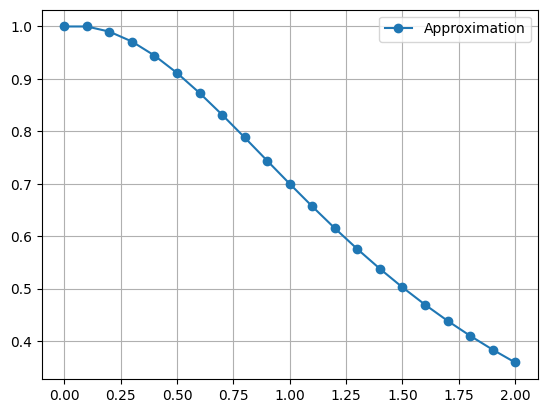

In [25]:
# parameters setting
t0 = 0
tf = 2
y0 = 1
h = 0.1

# calculate the solution
y, t = be(y0, t0, tf, h)

# plot the solution
plt.plot(t, y, 'o-', label='Approximation')
plt.legend()
plt.grid()

### Exact solution

Recall the ODE:
$$
y'= -ty^2 
$$

Let's solve algrebrically (separable variables DE):

$$
\frac{dy}{dt} = -ty^2
$$

$$
\frac{1}{y^2} \frac{dy}{dt} = -t
$$

$$
\frac{1}{y^2} dy = -t dt
$$

$$
\int{\frac{1}{y^2} dy} = \int{-t dt}
$$

$$
- \frac{1}{y} + C1 = -\frac{t^2}{2} + C2
$$

$$
\frac{1}{y} = \frac{t^2}{2} + C
$$

$$
y = \frac{1}{\frac{t^2}{2} + C}
$$

it must be $y(0) = 1$ so $C = 1$:

$$
y(t) = \frac{1}{\frac{t^2}{2} + 1}
$$

Error: 0.055397887326710665


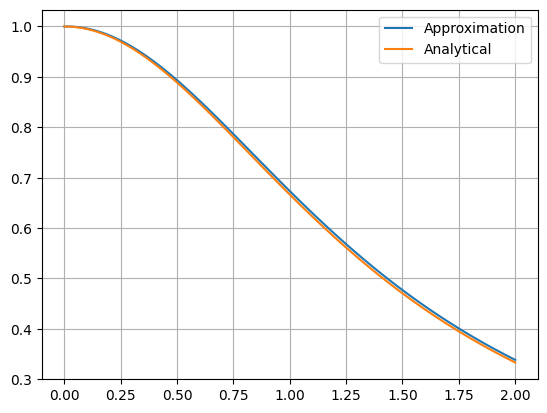

In [26]:
# parameters setting
t0 = 0
tf = 2
y0 = 1

# number of discretization points
num_points = 100

# calculate the solution
h = (tf - t0) / (num_points - 1)
y, t = be(y0, t0, tf, h)

# analitycal solution
exact = lambda t: 1/(t**2/2 + 1)

# plot solutions
plt.plot(t, y, '-', label='Approximation')
plt.plot(t, exact(t), label='Analytical')
plt.legend()
plt.grid()

# print error
error = np.linalg.norm(exact(t) - y, 2)
print('Error:', error)